In [1]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
import albumentations as A
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random
import utility
import rasterio
import wandb

In [2]:
# same seed
torch.manual_seed(0)

In [3]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [4]:
# CUDA
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
batch_size = 1
threshold = 0.5

In [6]:
def values_not_in_array(array1, array2):
    """"function that takes two arrays as input and returns a list 
    containing all the values in the first array that are not found in
     the second array:"""
    return [value for value in array1 if value not in array2]

In [7]:
class ShipDataset:
    def __init__(self, path, transform=None):
        self.path = path
        if path == "no_ship":
            allShipsTXT = os.listdir("annotations_yolo/")
            allShips = [ship[:-4] for ship in allShipsTXT]
            allImageJPG = os.listdir("images/")
            allImage = [img[:-4] for img in allImageJPG]
            nonShips = values_not_in_array(allImage,allShips)

            self.files = nonShips
        else:
            self.files = list(sorted(os.listdir(path)))
        
        self.transform = transform
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if self.path == "no_ship":
            file_image = self.files[idx] + '.jpg'
            file_label = self.files[idx] + '.xml'
        else:
            file_image = self.files[idx][:-3] + 'jpg'
            file_label = self.files[idx][:-3] + 'xml'

        img_path = os.path.join("images/", file_image)
        label_path = os.path.join("annotations/", file_label)
        #print(img_path,label_path)
        
        # Read an image with OpenCV, gray scale
        image = cv2.imread(img_path,0)
        
        image = image/255.0
        target = utility.generate_target(label_path)

        
        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = torch.Tensor(transformed['image'])
            target = {'boxes':torch.Tensor(transformed['bboxes']).reshape(-1,4), 'labels':torch.Tensor(transformed['labels'])}
        else:
            image = torch.tensor(image,dtype=torch.float32)
        
        image = torch.unsqueeze(image, dim=0)
            
        return image, target 

In [8]:
val_dataset = ShipDataset(
    path = 'test_yolo/',
    #transform=transform
)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,collate_fn=utility.collate_fn)
len(val_dataset)

509

In [9]:
noShip_dataset = ShipDataset(
    path = 'no_ship',
    #transform=transform
)

noShip_loader = torch.utils.data.DataLoader(noShip_dataset, batch_size=batch_size,collate_fn=utility.collate_fn)

In [10]:
len(noShip_dataset)

7141

### Load RetinaNet

In [55]:
model = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=2)
model.load_state_dict(torch.load("models/retina300R2.pt"))
model.eval()
model.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

### Load Faster R-CNN

In [25]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 2  # 1 class (ship) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("models/faster300ep.pt"))
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

### Load YOLOv7 

In [6]:
path = "models/yolov7d6.pt"
model = torch.hub.load("WongKinYiu/yolov7","custom",f"{path}",trust_repo=True)
model.eval()
model.to(device)

Using cache found in /home/alex/.cache/torch/hub/WongKinYiu_yolov7_main

                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                 

Adding autoShape... 


autoShape(
  (model): Model(
    (model): Sequential(
      (0): ReOrg()
      (1): Conv(
        (conv): Conv2d(12, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (2): DownC(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU()
        )
        (cv2): Conv(
          (conv): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU()
        )
        (cv3): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=T

### Visualizing results

In [64]:
def plot_ground_truth_and_predictions(model, data_loader, device,n):
    """
    model: model to predict
    data_loader: test_data loader to use
    device: the device to use
    n: random into scroll on images

    returns: none
    prints a random image from data_loader with both its ground truth and the models predictions
    """
    # TODO: Add a boolean for yolo model 
    # Get a batch of validation data

    data_loader = iter(data_loader)
    #images, targets = next(data_loader)
    images, targets = next(data_loader)
    
    for i in range(n):
        images, targets = next(data_loader)

    images = images[0]
    # Send the images and targets to the device
    images = images.to(device)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    images = torch.unsqueeze(images, dim=0)
    # Run the model on the images
    # TODO: ADD THRESHOLDING TO MODEL
    # TODO: Add a boolean for yolo model 
    outputs = model(images)

    # Loop over the images in the batch
    for i in range(len(images)):
        # Get the image, target boxes, and predicted boxes for this image
        image = images[i].cpu().permute(1, 2, 0).numpy()
        target_boxes = targets[i]['boxes'].cpu().numpy()
        predicted_boxes = outputs[i]['boxes'].detach().cpu().numpy()

        # Create a figure with two subplots
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot the ground truth boxes on the first subplot
        axs[0].imshow(image,cmap="gray")
        for box in target_boxes:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=2, edgecolor='g', facecolor='none')
            axs[0].add_patch(rect)
        axs[0].set_title('Ground Truth')
        axs[0].set_xticks([])
        axs[0].set_yticks([])

        # Plot the predicted boxes on the second subplot
        axs[1].imshow(image,cmap="gray")
        for box in predicted_boxes:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=2, edgecolor='r', facecolor='none')
            axs[1].add_patch(rect)
        axs[1].set_title('Predictions')
        axs[1].set_xticks([])
        axs[1].set_yticks([])
        # Show the plot
        plt.show()

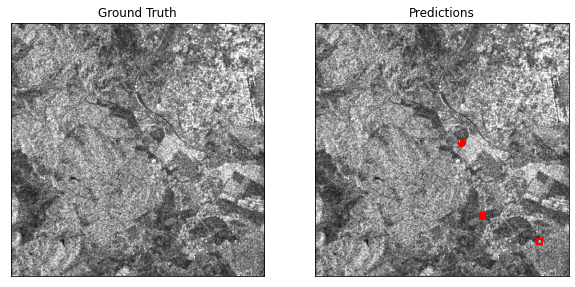

In [65]:
plot_ground_truth_and_predictions(model,noShip_loader,device,1)

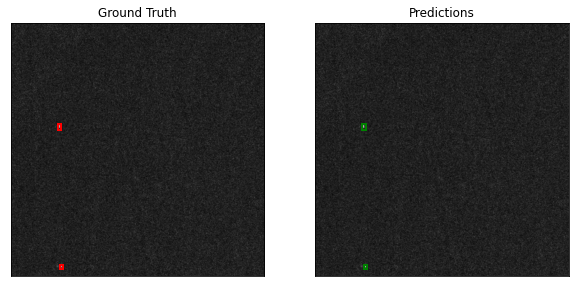

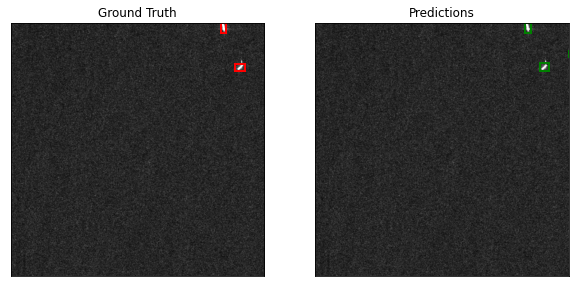

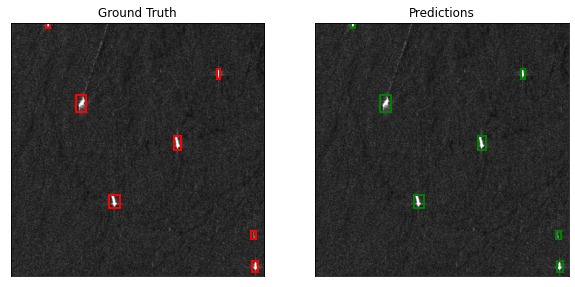

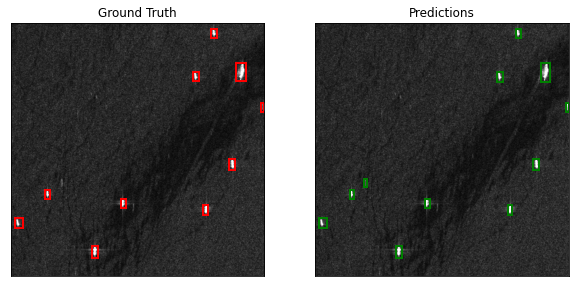

In [21]:
for i in range(4):
    plot_ground_truth_and_predictions(model,val_loader,device,i)

In [22]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(val_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = utility.make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 509/509 [00:35<00:00, 14.35it/s]


In [23]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utility.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))] 
precision, recall, AP, f1, ap_class = utility.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))

/tmp/ipykernel_19925/791575790.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


In [26]:
"Precision: {0} \n Recall: {1} \\n AP: {2} \n F1: {3} \n mAP {4}".format(precision.item(), recall.item(), AP.item(), f1.item(),mAP.item())

'Precision: 0.9144737124443054 \n Recall: 0.936887264251709 \\n AP: 0.9273502484059746 \n F1: 0.925544798374176'

### Test on no Ship images

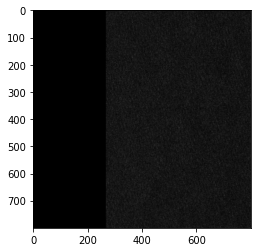

In [26]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
 
# Read Images
img = mpimg.imread("images/01_1_1.jpg")
 
# Output Images
plt.imshow(img)

In [13]:
allShipsTXT = os.listdir("annotations_yolo/")
allShips = [ship[:-4] for ship in allShipsTXT]

allImageJPG = os.listdir("images/")
allImage = [img[:-4] for img in allImageJPG]


In [15]:
def values_not_in_array(array1, array2):
    """"function that takes two arrays as input and returns a list 
    containing all the values in the first array that are not found in
     the second array:"""
    return [value for value in array1 if value not in array2]

In [19]:
# array of images file names that do not have ships
nonShips = values_not_in_array(allImage,allShips)
nonShips.sort()

In [23]:
len(nonShips)

7141

In [51]:
noShips = []
for i in range(30):
    temp1 = "images/01_1_{0}.jpg".format((i+1))
    if i < 21:
        temp2 = "images/01_2_{0}.jpg".format((i+1))
        noShips.append(temp2)
    noShips.append(temp1)
    

In [24]:
def test_no_ship(model, threshold, images):
    allIm = []
    for im in images:
        im = "images/{0}.jpg".format(im)
        image = cv2.imread(im,0)
        image = image/255.0
        image = torch.tensor(image,dtype=torch.float32)
        image = torch.unsqueeze(image, dim=0)
        image = image.to(device)
        allIm.append(image)
    
    
    numWrong = 0
    numIm = len(allIm)
    for im in allIm:
        im = torch.unsqueeze(im, dim=0)
        pred = model(im)

        if torch.sum(pred[0]["scores"]>threshold).item() > 0:
            #print(im)
            numWrong += 1

    return (numIm-numWrong)/float(numIm)


In [25]:
test_no_ship(model,threshold, nonShips)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.79 GiB total capacity; 6.70 GiB already allocated; 54.81 MiB free; 6.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Working with YOLOv7

In [27]:
image1 = cv2.imread("gee/2020-01-05_5.jpg",0)
plt.imshow(image1,cmap="gray")
plt.show()
image1 = np.clip(image1, -20, 0)

# for some reason have to rescale or else when saving image it will be dark
image1 = (image1-image1.min())/(image1.max()-image1.min())

#image = image1/255.0
image = torch.tensor(image1,dtype=torch.float32)
image = torch.unsqueeze(image, dim=0)
image = image.to(device)
test = [image]

/tmp/ipykernel_67423/2450062683.py:7: RuntimeWarning: invalid value encountered in true_divide
  image1 = (image1-image1.min())/(image1.max()-image1.min())


In [13]:
import matplotlib
matplotlib.use('TkAgg')

In [14]:
plt.imshow(image1)
plt.show()

In [28]:
image1 = cv2.imread("gee/2020-01-05_5.jpg",0)
image = image1/255.0

In [24]:
with rasterio.open(r'/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/gee_data/2020-01-05.tif') as src:
    img = src.read()
    img = np.clip(img, -20, 0)
    plt.imshow(img[0],cmap="gray")
    plt.show()
    img = (img-img.min())/(img.max()-img.min())
    plt.imshow(img[0],cmap="gray")
    
    plt.show()

In [30]:
res

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}]

In [29]:
res = model(test)

In [23]:
# Extract the bounding boxes, object confidence scores, and class IDs
boxes = res.xyxy[0]  # xyxy coordinates of boxes for first image in batch
scores = res.pred[0][:, 4]  # object confidence scores for first image in batch
class_ids = res.pred[0][:, 5]  # class IDs for first image in batch

In [31]:
boxes, scores

(tensor([[3.06875e+02, 2.04688e+02, 3.39375e+02, 2.49688e+02, 4.34082e-01, 0.00000e+00],
         [4.43125e+02, 2.25312e+02, 4.70625e+02, 2.67812e+02, 3.80371e-01, 0.00000e+00],
         [1.15781e+02, 4.12500e+01, 1.41094e+02, 8.83594e+01, 3.33740e-01, 0.00000e+00]], device='cuda:0'),
 tensor([0.43408, 0.38037, 0.33374], device='cuda:0'))

In [30]:
res.xyxy

[tensor([], device='cuda:0', size=(0, 6))]

In [18]:
res.pandas().xyxy[0].to_numpy()

array([[306.875, 204.6875, 339.375, 249.6875, 0.43408203125, 0, 'ship'],
       [443.125, 225.3125, 470.625, 267.8125, 0.38037109375, 0, 'ship'],
       [115.78125, 41.25, 141.09375, 88.359375, 0.333740234375, 0, 'ship']], dtype=object)

In [20]:
res.pandas().xyxy[0].to_numpy()[0]

array([306.875, 204.6875, 339.375, 249.6875, 0.43408203125, 0, 'ship'], dtype=object)

In [34]:
prediction = model(test)
prediction

[{'boxes': tensor([[388.5357,  47.7704, 455.0302,  75.9165],
          [300.4412, 182.6980, 355.8786, 213.4613],
          [428.8358, 208.7230, 489.9037, 236.0515],
          [174.0725, 195.8567, 224.4084, 216.5459],
          [250.6434,  17.3685, 313.7445,  43.0078]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9994, 0.9966, 0.9959, 0.9858, 0.7262], device='cuda:0',
         grad_fn=<IndexBackward0>)}]

In [37]:
sum(prediction[0]["scores"]>threshold).item()

5

In [37]:
torch.sum(prediction[0]["scores"]>0.5).item()

0

In [17]:
allFiles = os.listdir("images/")

In [19]:
allFiles.sort()

In [20]:
allFiles[:5]

['01_10_1.jpg', '01_10_10.jpg', '01_10_11.jpg', '01_10_12.jpg', '01_10_13.jpg']

In [7]:
import joblib

In [4]:
import sklearn
sklearn.__version__

'0.24.2'

In [5]:
from sklearn.neighbors import _dist_metrics

In [11]:
clf = joblib.load("inshore_offshore_clf_model.pkl")
img = cv2.imread("gee/2020-01-06_5.jpg",0)
img_vals = np.copy(img)
img_50 = np.percentile(img_vals,50)
img_80 = np.percentile(img_vals,80)
img_90 = np.percentile(img_vals,90)
img_30 = np.percentile(img_vals,30)
    
features = np.array([[img_50, img_80, img_90, img_30]])
calssres = clf.predict(features)

/home/alex/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [13]:
calssres[0]

1

## GEE Image Reading and Testing

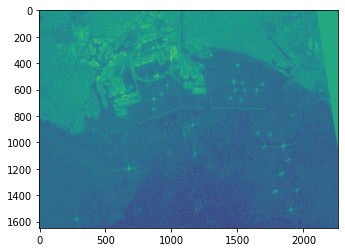

In [19]:
with rasterio.open(r'/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/gee_data/2020-01-11.tif') as src:
    img = src.read()
    plt.imshow(img[0])

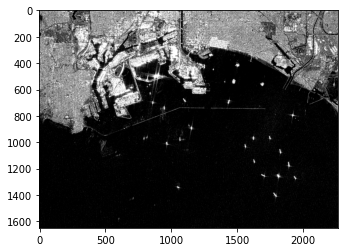

In [13]:
with rasterio.open(r'/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/gee_data/2020-01-06.tif') as src:
    img = src.read()
    img = np.clip(img, -20, 0)
    plt.imshow(img[0],cmap="gray")

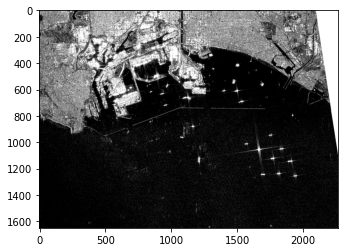

In [11]:
with rasterio.open(r'/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/gee_data/2020-01-05.tif') as src:
    img = src.read()[0]
    img = np.clip(img, -20, 0)
    plt.imshow(img,cmap="gray")
    # img = Image.fromarray(img)
    # img = img.convert("L")
    # img.save("test.jpg")

In [ ]:
## TODO: Fix YOLO
## TODO: Figure out thresholding
## TODO: Metrics for no ships


In [40]:
## TODO: plot bounding box on large image

In [7]:
def image_splitter(img_fp):
    """
    Takes the image filepath returns m x n array of the subimages
    pads with 0
    """
    #     img = gdal.Open(img_fp)
    #     img_array = img.GetRasterBand(1).ReadAsArray()
    # note have to add in rescaled helper fn

    # define splitting helper function
    # got this from https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7
    def reshape_split(image, kernel_size):
        img_height, img_width = image.shape
        tile_height, tile_width = kernel_size
        
        tiled_array = image.reshape(img_height // tile_height,
                                tile_height,
                                img_width // tile_width,
                                tile_width)
        tiled_array = tiled_array.swapaxes(1,2)
        return tiled_array


    # get image name to return
    # splits full fp by \, then gets the YYYY-MM-DD_#.jpg, then cuts off .jpg 
    img_name = img_fp.split('\\')[-1][:-4]



    with rasterio.open(img_fp) as src:
        img_array = src.read()[0]
        #print(img_array.shape)
        
    # have to clip values to take away gray tint from image
    # and have to do this so that inshore offshore classifier works
    img_array = np.clip(img_array, -20, 0)
    
    img_height, img_width = img_array.shape
    # get next biggest multiple of 800
    # TODO: Make it closest multiple of 800 instead OR PAD WITH BLACK
    new_height = img_height + (800 - img_height % 800)
    new_width = img_width + (800 - img_width % 800)
    
    # calculate number of pixels to pad
    delta_w = new_width - img_width
    delta_h = new_height - img_height
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    # pad image with 0
    image_pad = np.pad(img_array, ((top, bottom), (left, right)), mode='constant', constant_values=-20)
    
    # for some reason have to rescale or else when saving image it will be dark
    rescaled = 255*(image_pad-image_pad.min())/(image_pad.max()-image_pad.min())

    # normalize between 0 and 1
    # MAKE A BETTER RESCALING
    rescale_normalized = rescaled / 255
    
    # split image into subimages
        # will return array [m, n, 800, 800] where there are an m x n number of images with size 800x800 
    split = reshape_split(rescale_normalized, kernel_size=(800,800))
    
    return split, img_name

In [8]:
def plot_large_image(model,image_path,threshold,save_path):
    """
    model: pytorch 
    image_path: path tif file
    threshold: confidence threshold for model
    save_path: path to save plot (must be jpg), if none will not save
    """

    # split image and save size for future
    split_image, _ = image_splitter(image_path)
    split_size = split_image.shape[:2]

    # flatten image and format to work with pytroch device
    flattened = np.reshape(split_image, (-1, split_image.shape[2], split_image.shape[3]))
    torch_split_img = np.array(flattened)
    torch_split_img = torch.tensor(torch_split_img,dtype=torch.float32)
    torch_split_img = torch.unsqueeze(torch_split_img, dim=0)
    torch_split_img = torch_split_img.permute(1,0,2,3)
    torch_split_img = torch_split_img.to(device)

    # predict bounding boxes
    pred = model(torch_split_img)
    # reshape to match image split
    pred = np.reshape(pred,split_size)


    # Create a 3x3 plot with a shared axis
    fig, axs = plt.subplots(split_size[0], split_size[1], sharex=True, sharey=True, figsize=(6, 6))

    # Loop over the images and annotations and plot them on the corresponding subplot
    for i in range(split_size[0]):
        for j in range(split_size[1]):
            # Plot the image
            axs[i, j].imshow(split_image[i, j], cmap='gray')
            
            # Remove the axis labels and ticks
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].axis('off')
            # Loop over the annotations and plot them as bounding boxes
            curPred = pred[i, j]
            for k in range(len(curPred["scores"])):
                # checks if above threshold
                if curPred["scores"][k] > threshold:
                    annotation = curPred['boxes'][k]
                    annotation = annotation.cpu().detach().numpy()
                    left, upper, right, lower = annotation
                    width, height = right - left, lower - upper
                    rect = plt.Rectangle((left, upper), width, height, linewidth=1, edgecolor='r', facecolor='none')
                    axs[i, j].add_patch(rect)

    # Remove the space between the images
    plt.subplots_adjust(wspace=0, hspace=0)
    if save_path:
        plt.savefig(save_path,quality=100,dpi=500)
    # Show the plot
    plt.show()

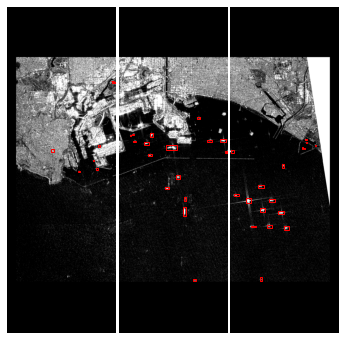

In [9]:
plot_large_image(model,r'/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/gee_data/2020-01-05.tif',threshold,None)

In [7]:
faster_rcnn = model

In [10]:
testing, _ = image_splitter('/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/gee_data/2020-01-05.tif')

In [12]:
testing.shape[:2]

(3, 3)

In [11]:
flattened = np.reshape(testing, (-1, testing.shape[2], testing.shape[3]))

In [12]:
inshoreImg = np.array(flattened)
inshoreImg = torch.tensor(inshoreImg,dtype=torch.float32)
inshoreImg = torch.unsqueeze(inshoreImg, dim=0)
inshoreImg = inshoreImg.permute(1,0,2,3)
inshoreImg = inshoreImg.to(device)

In [13]:
testPred = faster_rcnn(inshoreImg)

In [19]:
testPred = np.reshape(testPred,(3,3))

In [21]:
testPred[0,0]

{'boxes': tensor([[775.1910, 552.0970, 785.3232, 560.4473],
         [787.7794, 552.0059, 796.8090, 561.7679],
         [765.2172, 543.5808, 776.0449, 549.4780],
         [773.5134, 549.6494, 787.4072, 562.0412],
         [764.9692, 541.1521, 776.9842, 547.7147],
         [776.1341, 537.3970, 786.8801, 543.2408],
         [763.5697, 544.5361, 773.8850, 551.0873],
         [776.1281, 535.1804, 788.0169, 541.0664],
         [768.3798, 539.0614, 781.4567, 545.3739],
         [768.9927, 536.9083, 781.9061, 543.0823]], device='cuda:0',
        grad_fn=<StackBackward0>),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9957, 0.8348, 0.5494, 0.5066, 0.3686, 0.2138, 0.2028, 0.1295, 0.0903,
         0.0832], device='cuda:0', grad_fn=<IndexBackward0>)}

/tmp/ipykernel_8814/2327292663.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('my_plot.jpg',quality=100,dpi=500)


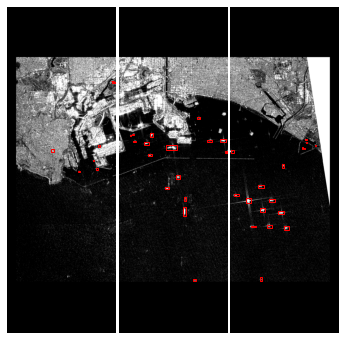

In [48]:
# Create a 3x3 plot with a shared axis
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(6, 6))

# Loop over the images and annotations and plot them on the corresponding subplot
for i in range(3):
    for j in range(3):
        # Plot the image
        axs[i, j].imshow(testing[i, j], cmap='gray')
        
        # Remove the axis labels and ticks
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].axis('off')
        # Loop over the annotations and plot them as bounding boxes
        #print(testPred)
        curPred = testPred[i, j]
        #print(len(curPred["scores"]))
        for k in range(len(curPred["scores"])):
            #print(curPred["scores"])
            if curPred["scores"][k] > 0.5:
                annotation = curPred['boxes'][k]
                annotation = annotation.cpu().detach().numpy()
                left, upper, right, lower = annotation#.detach().numpy()
                width, height = right - left, lower - upper
                rect = plt.Rectangle((left, upper), width, height, linewidth=1, edgecolor='r', facecolor='none')
                axs[i, j].add_patch(rect)

# Set the axis labels
#fig.text(0.5, 0.04, 'X', ha='center')
#fig.text(0.04, 0.5, 'Y', va='center', rotation='vertical')

# Remove the space between the images
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('my_plot.jpg',quality=100,dpi=500)
# Show the plot
plt.show()